In [49]:
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import os
import random

yf.pdr_override()

pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

In [135]:
# This function gets the relevant stocks or cryptocurrencies close prices between 2020-01-22 and yesterday from Yahoo Fiannce. 
def yahoo_download(symbols):
    return pdr.get_data_yahoo(symbols, start="2020-01-22")['Adj Close'][symbols]

# This function returns to the U.S. Covid-19 related indices that we consider to be usful for the project.
# Replace the NaN values at the beginning of the pandemic by zeroes. 
# Convert the "date" column type and set it to be the index, so that it can be properly merged with another dataframe.   
def get_covid_data():
    df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
    covid_data = df[df['location']=='United States'][['date', 'total_cases', 'new_cases', 
                    'total_deaths', 'new_deaths', 'new_tests', 'total_tests',
                    'positive_rate', 'total_vaccinations', 'people_vaccinated']]
    covid_data.fillna(0, inplace=True)
    covid_data['date'] = covid_data['date'].astype('datetime64[ns]')
    covid_data.set_index('date', inplace=True)
    return covid_data

# The return value of this function is a dataframe that contains all tha relevant data we need in this project.
# "symbols" specifies the stocks and cryptocurrencies that we choose to use.
# "SPY" represents the S&P 500 Index. 
# "TSLA", "FB", "AAPL", and "MSFT" are four U.S. tech stocks.
# "BTC-USD", "ETH-USD", "ADA-USD", "XRP-USD", "DOGE-USD", "LTC-USD", "XLM-USD", "LINK-USD" are eight mainstream cryptocurrencies in US dollars.
# Users can control the data they want to use for modeling.
# If needed, merge the stocks, cryptocurrencies and Covid-19 data using row labels from both the left and right dataframe as joint union of keys.
def get_data(use_stock=True, use_covid19=True):
    crypto_symbols = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'XRP-USD', 
                      'DOGE-USD', 'LTC-USD', 'XLM-USD', 'LINK-USD']
    stocks_symbols = ['SPY', 'GOOG', 'TSLA', 'FB', 'AAPL', 'MSFT']
    data = yahoo_download(crypto_symbols)[:-1]
    data = data.merge(get_covid_data(), left_index=True, right_index=True, how='right').fillna(method='ffill')
    if not use_covid19:
        data = data[data.columns[:8]]
    if use_stock:
        data = data.merge(yahoo_download(stocks_symbols)[:-1], left_index=True, right_index=True, how='left')
    return data

# This function preprocesses the data for the LSTM Model.
# Forward fill the NaN value in the data set. 
# We use the featured data (X) from each past 90 days to predict the price of Bitcoin (Y) the day after.
# Normalize the raw data and reshape them into desired matrix shape.
# Users can control whether it is for research purpose. If yes, it will test the model on all data. If no, it will only predict the today's close price.
def preprocess_data(data, is_research=False):
    features = data.columns
    data = data.fillna(method='ffill')
    raw_X = MinMaxScaler().fit_transform(data[features])
    raw_y = MinMaxScaler().fit_transform(data['BTC-USD'].values.reshape(len(data), 1)) 
    train_X = np.array([raw_X[i-90:i] for i in range(90, len(raw_X))]) 
    train_y = raw_y[90:] 
    if is_research:
        test_X = np.array([raw_X[i-90:i] for i in range(90, len(raw_X))]) 
        print(f'Downloaded data with {data.shape[0]} rows and {data.shape[1]} columns')
        print(f'Used features: {list(data.columns)}')
    else:
        test_X = np.array([raw_X[-90:]])    
    return train_X, train_y, test_X
 
# This function builds a stacked long short-term memory (LSTM) model using the Keras library.
# It uses three LSTM layers and one dense layer to make the model deeper and more accurate.
# The "shape" of the LSTM input layer needs to be of 3D matrix format. The optimization method is "adam".
def build_model(shape, optimizer):
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    random.seed(12345)
    np.random.seed(12345)
    tf.random.set_seed(12345)
    
    model = tf.keras.Sequential()
    model.add(LSTM(units=32, return_sequences=True,
                    input_shape=shape, dropout=0.2))
    model.add(LSTM(units=32, return_sequences=True,
                    dropout=0.2))
    model.add(LSTM(units=32, dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# This function returns to the result of the LSTM model.
# "epoch" and "batch_size" are parameters of the model. 
# Set "verbose" to zero so that we can avoid to see the training progress of each epoch.
# "[es]" stands for "early stop", which asks to stop training when the loss can not be reduced anymore.
# Return to the fitting result (loss) of the last epoch, and apply the trained model to make predictions.
def model_results(train_X, train_y, test_X, es):
    model = build_model(train_X.shape[1:], 'adam')
    history = model.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0, callbacks=[es])
    return history.history['loss'][-1], model.predict(test_X)
  
# Draw mutiple plots that presents the real Bitcoin prices and predicted results when using dirrerent featured data to make predictions.
# Convert the normolized Bitcoin prices back to its original value.
# The plt.subplots function in Matplotlib helps with creating multiple subplots in one graph.
def plot_comparision(data, prediction_list, titles):
    f, axs = plt.subplots(len(prediction_list), 1, figsize=(16,16))
    for i in range(len(prediction_list)):
        axs[i].plot(data.index[90:], data['BTC-USD'].values[90:], color='blue', label='Real')
        axs[i].plot(data.index[90:], prediction_list[i], color='red', label='Prediction')
        axs[i].set_title(titles[i])
        axs[i].set_ylabel('BTC-USD price')
    plt.legend()
    plt.show()

# Rescaled the predictions to original range. 
# This is because we used MinMaxScaler to scale the normal price into [0,1]. But now we need the original price range.
def rescaling(data, predictions):
    min_price = min(data['BTC-USD']) 
    price_range = max(data['BTC-USD']) - min_price
    return [p * price_range + min_price for p in predictions]

# the main function of our busniness applications. 
# Users can control whether to use stock and covid19 data for modeling.
# Users also can control whether to use it for research puurpose or for application (i.e. prediction for today's closed price).
def forecasting_model(use_stock=False, use_covid19=False, is_research=False):
    data = get_data(use_stock, use_covid19)
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10) 
    last_loss, predictions = model_results(*preprocess_data(data, is_research), es)
    return last_loss, rescaling(data, predictions)

In [139]:
# Create two lists to store the LSTM model results.
last_loss_list = [0] * 4 
prediction_list = [0] * 4

In [140]:
# This block uses only the prices of cryptocurrencies from the past 90 days to predict the price of Bitcoin the day after.
last_loss_list[0], prediction_list[0] = forecasting_model(use_stock=False, use_covid19=False, is_research=True)
print(f'The final loss of the model: {last_loss_list[0]}')

[*********************100%***********************]  8 of 8 completed
Downloaded data with 675 rows and 8 columns
Used features: ['BTC-USD', 'ETH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD', 'LINK-USD']
Epoch 00079: early stopping
The final loss of the model: 0.002054572803899646


In [141]:
# This block uses the prices of cryptocurrencies and stocks to make predictions on the Bitcoin prices.
last_loss_list[1], prediction_list[1] = forecasting_model(use_stock=True, use_covid19=False, is_research=True)
print(f'The final loss of the model: {last_loss_list[1]}')

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed
Downloaded data with 675 rows and 14 columns
Used features: ['BTC-USD', 'ETH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD', 'LINK-USD', 'SPY', 'GOOG', 'TSLA', 'FB', 'AAPL', 'MSFT']
The final loss of the model: 0.0020997002720832825


In [142]:
# This block uses the prices of cryptocurrencies and Covid-19 indices to make predictions.
last_loss_list[2], prediction_list[2] = forecasting_model(use_stock=False, use_covid19=True, is_research=True)
print(f'The final loss of the model: {last_loss_list[2]}')

[*********************100%***********************]  8 of 8 completed
Downloaded data with 675 rows and 17 columns
Used features: ['BTC-USD', 'ETH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD', 'LINK-USD', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'new_tests', 'total_tests', 'positive_rate', 'total_vaccinations', 'people_vaccinated']
Epoch 00074: early stopping
The final loss of the model: 0.0016307731857523322


In [143]:
last_loss_list[3], prediction_list[3] = forecasting_model(use_stock=True, use_covid19=True, is_research=True)
print(f'The final loss of the model: {last_loss_list[3]}')

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed
Downloaded data with 675 rows and 23 columns
Used features: ['BTC-USD', 'ETH-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'LTC-USD', 'XLM-USD', 'LINK-USD', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'new_tests', 'total_tests', 'positive_rate', 'total_vaccinations', 'people_vaccinated', 'SPY', 'GOOG', 'TSLA', 'FB', 'AAPL', 'MSFT']
Epoch 00092: early stopping
The final loss of the model: 0.0019223657436668873


In [144]:
# Display the prediction loss when using different columns to make predictions on Bitcoin prices.
titles = ['Only Using Crypto', 'Combine Crypto and Stock', 'Combine Crypto and COVID-19', 'Combine Crypto, Stock, and COVID-19']

for i in range(4):
    print('The loss of {:^40}: {}'.format(titles[i], last_loss_list[i]))

The loss of            Only Using Crypto            : 0.002054572803899646
The loss of         Combine Crypto and Stock        : 0.0020997002720832825
The loss of       Combine Crypto and COVID-19       : 0.0016307731857523322
The loss of   Combine Crypto, Stock, and COVID-19   : 0.0019223657436668873


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed


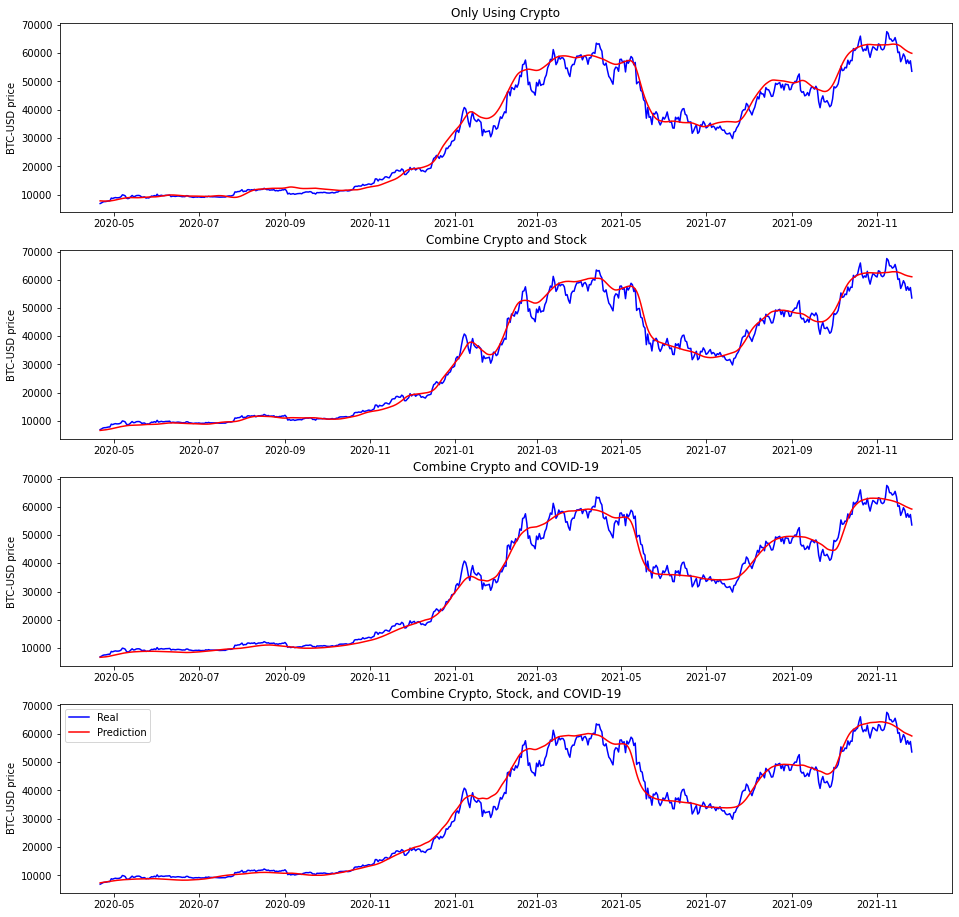

In [145]:
data = get_data()
plot_comparision(data, prediction_list, titles)

In [146]:
data = get_data()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed


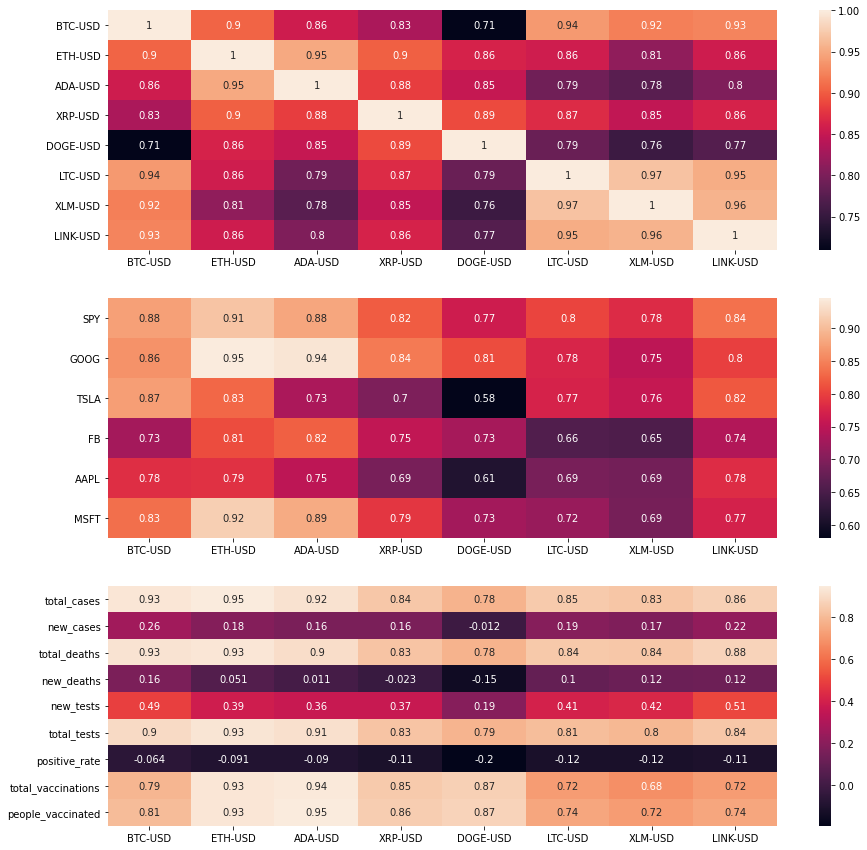

In [151]:
f,(ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 15))
corr_matrix = data.corr()
sns.heatmap(corr_matrix.iloc[:8, :8], annot=True, ax=ax1)
sns.heatmap(corr_matrix.iloc[17:, :8], annot=True, ax=ax2)
sns.heatmap(corr_matrix.iloc[8:17, :8], annot=True, ax=ax3)
plt.setp(ax2.get_yticklabels(), rotation=0)
plt.show()

In [152]:
_, prediction = forecasting_model(use_stock=False, use_covid19=True, is_research=False)
print(f"The Prediction of Today's Closed Price: {prediction[0][0]}")


[*********************100%***********************]  8 of 8 completed
Epoch 00074: early stopping


In [155]:
print(f"The Prediction of Today's Closed Price: {prediction[0][0]}")

The Prediction of Today's Closed Price: 59017.53515625
